### Imports

In [1]:
#custom libraries
from data_import import *
from data_preprocess import *
from data_preprocess_BERT import *

In [10]:
#set filepath constants
NLP_TOPIC_RECOGNITION_FILEPATH = '../NLP Topic Recognition'
#NLP_MODEL_FILEPATH = '../NLP Model Training/model_100K_glove'
#NLP_MODEL_FILEPATH = '../NLP Model Training/model_100K_glove_91'
NLP_MODEL_FILEPATH = '../NLP Model Training/model_1M_glove'
# TEXTUAL_RAW_DATA_FILEPATH = '../Data/textual_raw'
TEXTUAL_RAW_DATA_FILEPATH = '../Data/Files_full'
## Glove 0.91
#OUTPUT_DATASET_FILEPATH = "glove_1M_full_dates_min.csv"
# OUTPUT_DATASET_FILEPATH = "glove_100k_91_min.csv"
# OUTPUT_DATASET_FILEPATH = "BTC_open_close.csv"
# OUTPUT_DATASET_FILEPATH = "Dataset_sentiment_100K_91_glove_filtered_full_end_start.csv"
# OUTPUT_DATASET_FILEPATH = "Dataset_sentiment_100K_glove_91_filtered_full_user_averaged.csv"
# OUTPUT_DATASET_FILEPATH = "Dataset_sentiment_100K_glove_91_filtered_full_user_weights_user_averaged.csv"

## Glove standar
# OUTPUT_DATASET_FILEPATH = "Dataset_sentiment_100K_glove_filtered_full_user_weights_user_averaged.csv"
# OUTPUT_DATASET_FILEPATH = "Dataset_sentiment_100K_glove_filtered_full_user_weights.csv"
# OUTPUT_DATASET_FILEPATH = "Dataset_sentiment_100K_glove_filtered_2g_user_weights.csv"

## BERT
OUTPUT_DATASET_FILEPATH = "Dataset_sentiment_BERT_trainable_full_dates_min.csv"
# OUTPUT_DATASET_FILEPATH_PREV = "Dataset_sentiment_BERT_trainable.csv"
# OUTPUT_DATASET_FILEPATH = "Dataset_sentiment_BERT_trainable_full.csv"

In [11]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append(NLP_TOPIC_RECOGNITION_FILEPATH)
#from topic_recognition import *
#from NLP_class import *

In [4]:
#bert.model.summary()
SENTIMENT_LABELLED_DATA_FILEPATH = '..\Data\Sentiment Analysis Dataset.csv'
txt_data = pd.read_csv(SENTIMENT_LABELLED_DATA_FILEPATH , sep='|', names=['col1'])

#split data into columns with ','
txt_data = txt_data.col1.str.split(',',  3, expand=True)
txt_data.columns = list(txt_data.iloc[0])
txt_data = txt_data.drop(0)
txt_data.index = np.subtract(txt_data.index, 1)

In [12]:
txt_data

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...
...,...,...,...,...
1577833,1578623,1,Sentiment140,Zzzzzz.... Finally! Night tweeters!
1577834,1578624,1,Sentiment140,"""Zzzzzzz, sleep well people """
1577835,1578625,0,Sentiment140,ZzzZzZzzzZ... wait no I have homework.
1577836,1578626,0,Sentiment140,"""ZzZzzzZZZZzzz meh, what am I doing up again? """


In [5]:
from tensorflow import keras
model = keras.models.load_model(NLP_MODEL_FILEPATH)

#### Model

In [6]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           57142400  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 57,222,901
Trainable params: 80,501
Non-trainable params: 57,142,400
_________________________________________________________________


In [7]:
# # returns a dictionary of the form {'username': (sentiment_score_sum, occurances)}
# def get_users(paths):
#     df = pd.DataFrame()
#     for path in paths:
#         text_data = preprocess_textual(path)
#         df = pd.concat([df, text_data])
    
#     #take the set of all usernames
#     ini_set = set(df['username'].values)
#     #initialized as neutral (0.5) and 1 occurance
#     users = dict.fromkeys(ini_set, (0.5,1))
#     return users
# updates username's sentiment score values after recieving username's tweet
# def user_update(username, sentiment):
#     #update 
#     if username in users:
#         (s,t) = users[username]
#     else:
#         (s,t) = (0.0, 1)
#     (s_new, t_new) = (s + sentiment, t + 1)
#     users[username] = (s_new, t_new)
    
#     #sentiment calculation sentiment_weighted has range(-1, 1)
#     #the extreme values are seen when a positive (on average) user tweets something really negative and the converse
#     sentiment_weighted = sentiment - s/t
#     return sentiment_weighted

class UserSentiment(object):
    
    def __init__(self):
        self.users = dict()
    
    def updateX(self, username, sentiment):
        if username in self.users:
            mean, count = self.users[username][0], self.users[username][1]
            # recursive mean update rule
            self.users[username][0] = mean * count / (count + 1) + sentiment/(count + 1)
            self.users[username][1] += 1
        else:
            self.users[username] = [sentiment, 1]
        return sentiment - self.users[username][0]
    
    #return 0 at first visit
    def update1(self, username, sentiment):
        if username in self.users:
            self.users[username][0] += sentiment
            self.users[username][1] += 1
        else:
            self.users[username] = [sentiment, 1]
        return sentiment - self.users[username][0]/self.users[username][1]
    
    #assume neutrality at first
    def update2(self, username, sentiment):
        if username not in self.users:
            self.users[username] = [0.5, 1]
        s, t = self.users[username][0], self.users[username][1]
        self.users[username][0] += s + sentiment
        self.users[username][1] += t + 1
        return sentiment - s/t

In [8]:
#Create a bert_preprocess object that automatically sets tokenizers and pretrained bert model classifier
bert = BERT_preprocess()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

##### Model Evaluation

In [13]:
df = txt_data
df["text"] = df["SentimentText"]
df["target"] = df["Sentiment"]
df

,ItemID,Sentiment,SentimentSource,SentimentText,text,target
0,1,0,Sentiment140,is so sad for my APL frie...,is so sad for my APL frie...,0
1,2,0,Sentiment140,I missed the New Moon trail...,I missed the New Moon trail...,0
2,3,1,Sentiment140,omg its already 7:30 :O,omg its already 7:30 :O,1
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...,.. Omgaga. Im sooo im gunna CRy. I'...,0
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...,i think mi bf is cheating on me!!! ...,0
...,...,...,...,...,...,...
1577833,1578623,1,Sentiment140,Zzzzzz.... Finally! Night tweeters!,Zzzzzz.... Finally! Night tweeters!,1
1577834,1578624,1,Sentiment140,"""Zzzzzzz, sleep well people ""","""Zzzzzzz, sleep well people """,1
1577835,1578625,0,Sentiment140,ZzzZzZzzzZ... wait no I have homework.,ZzzZzZzzzZ... wait no I have homework.,0
1577836,1578626,0,Sentiment140,"""ZzZzzzZZZZzzz meh, what am I doing up again? ""","""ZzZzzzZZZZzzz meh, what am I doing up again? """,0


In [121]:
y_pred = bert.predict(df.text[:20000])

In [60]:
test_labels

[0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0

In [122]:
y_pred_keras = np.round(y_pred).ravel()
test_labels = list(df.target[:20000].astype(float).values)

In [123]:
from sklearn.metrics import roc_curve, classification_report

fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, y_pred)

In [124]:
thresholds_keras

array([1.9951162 , 0.99511623, 0.9943732 , ..., 0.01229568, 0.01228995,
       0.01097265], dtype=float32)

In [144]:
print(classification_report(test_labels, y_pred_keras))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [126]:
tpr_keras

array([0.00000000e+00, 1.07573150e-04, 1.61359725e-03, ...,
       9.99892427e-01, 1.00000000e+00, 1.00000000e+00])

In [127]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(train_padded, train_labels)

y_pred_rf = rf.predict_proba(test_padded)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_labels, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

NameError: name 'train_padded' is not defined

In [128]:
plt.style.use('seaborn')

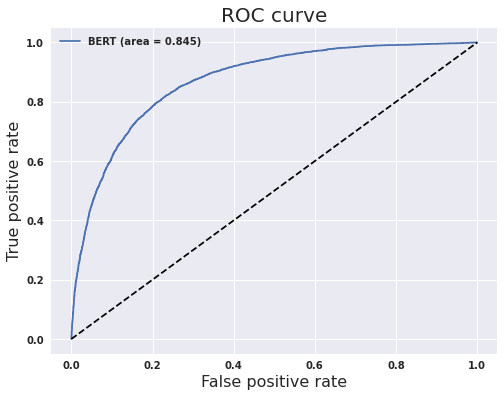

In [139]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr_keras, tpr_keras, label='BERT (area = {:.3f})'.format(auc_keras))
#ax.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_title('ROC curve', fontsize=20)
ax.set_xlabel('False positive rate', fontsize=16)
ax.set_ylabel('True positive rate', fontsize=16)
leg = ax.legend(loc='best')
fig.savefig('BERT_ROC.png', facecolor='w')
plt.show()


In [130]:
test_labels = np.array(test_labels)

In [131]:
import matplotlib
font = {'family' : 'normal',
  'weight' : 'bold',
  'size' : 18}
matplotlib.rc('font', **font)

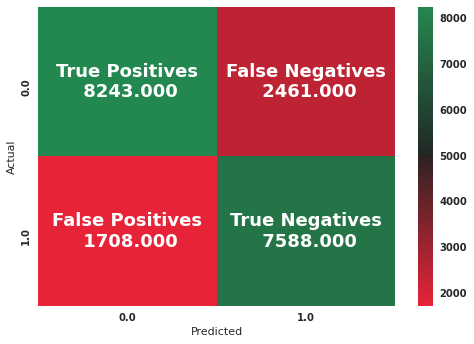

In [142]:
import seaborn as sn


cmap = sn.diverging_palette(10, 140, s=90, l=50, n=100,sep=1,center = 'dark', as_cmap=True)

confusion_matrix = pd.crosstab(test_labels, y_pred_keras, rownames=['Actual'], colnames=['Predicted'])
strings = strings = np.asarray([['True Positives\n', 'False Negatives\n'],
                                ['False Positives\n', 'True Negatives\n']])
labels = (np.asarray(["{0} {1:.3f}".format(string, value)
                      for string, value in zip(strings.flatten(),
                                               confusion_matrix.values.flatten())])
         ).reshape(2, 2)

fig, ax = plt.subplots()
sn.heatmap(confusion_matrix, annot=labels, fmt="", cmap=cmap, ax=ax)
fig.savefig('BERT_confusion.png', facecolor='w')
plt.show()


In [5]:
from tensorflow import keras
model = keras.models.load_model('../NLP Model Training/elmo_100K_trainable')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           10680300  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 10,760,801
Trainable params: 80,501
Non-trainable params: 10,680,300
_________________________________________________________________


In [6]:
path = '../NLP Model Training/tokenizer_1M.pickle'
with open(path, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [36]:
tokenizer

In [22]:
test_labels =[]
y_pred_keras = []
for i,r in df.sample(1000).iterrows():
    df_sequences = tokenizer.texts_to_sequences(r["text"])
    df_padded = (pad_sequences(
        df_sequences, maxlen=50, padding="post", truncating="post"
    ))
    y_pred_keras.append(round(model.predict(df_padded)[0][0]))
    test_labels.append(round(float(r["Sentiment"])))

In [24]:
print(classification_report(test_labels, y_pred_keras))

NameError: name 'classification_report' is not defined

In [23]:
y_pred_keras

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [41]:
res = model.predict(df_padded)

ValueError: Data cardinality is ambiguous:
  x sizes: 42, 28, 51, 30, 19, 88, 71, 24, 40, 22, 22, 36, 75, 34, 30, 58, 28, 26, 98, 21, 14, 68, 49, 47, 63, 20, 102, 76, 47, 37, 70, 13, 84, 38, 103, 83, 82, 12, 14, 68, 53, 39, 23, 89, 31, 50, 14, 41, 65, 67, 36, 35, 29, 19, 64, 26, 86, 31, 61, 60, 39, 14, 31, 77, 19, 29, 32, 62, 54, 76, 36, 95, 31, 60, 21, 85, 15, 82, 73, 41, 67, 62, 25, 72, 15, 23, 76, 13, 58, 74, 59, 72, 29, 85, 76, 58, 39, 83, 34, 31, 29, 16, 76, 88, 83, 62, 41, 37, 91, 36, 23, 11, 29, 46, 74, 72, 35, 73, 38, 81, 61, 48, 97, 75, 63, 45, 35, 47, 46, 65, 65, 112, 37, 73, 14, 78, 19, 48, 49, 77, 67, 27, 9, 70, 47, 55, 42, 30, 68, 29, 35, 23, 17, 31, 22, 48, 23, 27, 14, 13, 42, 25, 24, 53, 20, 39, 99, 45, 89, 89, 52, 45, 88, 64, 29, 16, 69, 89, 14, 28, 48, 27, 13, 91, 50, 28, 40, 8, 19, 35, 37, 55, 22, 95, 24, 40, 30, 55, 43, 61, 41, 77, 46, 68, 26, 22, 84, 36, 14, 69, 66, 39, 10, 47, 23, 27, 34, 56, 15, 80, 42, 30, 67, 79, 49, 81, 52, 84, 49, 51, 28, 21, 52, 90, 12, 33, 22, 29, 40, 12, 42, 56, 29, 46, 30, 14, 51, 77, 54, 33, 72, 106, 54, 39, 68, 30, 19, 66, 21, 25, 69, 36, 81, 84, 102, 45, 15, 50, 84, 27, 78, 51, 68, 26, 27, 14, 23, 47, 37, 32, 60, 46, 87, 30, 80, 68, 63, 38, 94, 56, 33, 67, 19, 50, 44, 44, 21, 66, 92, 47, 28, 68, 39, 29, 25, 17, 83, 60, 4, 34, 73, 67, 43, 91, 32, 85, 21, 17, 45, 50, 40, 71, 23, 99, 26, 26, 100, 32, 79, 11, 53, 87, 14, 51, 88, 14, 25, 42, 24, 16, 35, 52, 45, 77, 89, 74, 25, 35, 19, 14, 87, 72, 40, 90, 111, 21, 55, 13, 69, 32, 93, 96, 59, 17, 25, 24, 36, 48, 68, 54, 64, 47, 55, 77, 68, 29, 7, 69, 28, 62, 37, 42, 85, 68, 19, 27, 75, 24, 34, 19, 17, 29, 42, 81, 20, 97, 67, 8, 46, 95, 28, 42, 24, 95, 44, 46, 44, 56, 27, 88, 43, 60, 32, 33, 10, 76, 62, 38, 25, 75, 77, 23, 99, 94, 23, 32, 92, 63, 62, 26, 99, 12, 39, 50, 63, 30, 59, 51, 15, 50, 68, 56, 34, 40, 15, 31, 8, 15, 82, 17, 26, 35, 91, 57, 99, 88, 87, 16, 77, 46, 35, 69, 61, 38, 26, 29, 38, 34, 61, 25, 69, 41, 36, 46, 67, 99, 84, 48, 44, 60, 69, 64, 67, 31, 40, 57, 11, 96, 33, 66, 43, 25, 43, 87, 47, 40, 73, 32, 36, 39, 63, 46, 23, 57, 75, 71, 72, 76, 35, 76, 20, 49, 36, 100, 44, 24, 84, 42, 27, 58, 79, 37, 67, 32, 42, 22, 20, 59, 28, 29, 8, 50, 75, 37, 39, 56, 28, 84, 27, 76, 42, 42, 40, 43, 17, 19, 75, 24, 52, 32, 36, 26, 95, 56, 76, 27, 47, 50, 39, 39, 21, 40, 20, 10, 45, 88, 102, 49, 25, 51, 35, 28, 86, 59, 61, 74, 38, 24, 22, 38, 78, 45, 95, 32, 30, 24, 90, 53, 67, 15, 14, 70, 39, 28, 15, 34, 65, 19, 47, 44, 63, 31, 54, 9, 52, 38, 49, 59, 47, 89, 25, 63, 13, 58, 95, 35, 91, 45, 78, 15, 66, 53, 93, 35, 27, 59, 29, 64, 69, 87, 54, 23, 81, 62, 36, 102, 46, 96, 16, 66, 65, 20, 83, 60, 65, 70, 86, 37, 83, 43, 26, 47, 29, 86, 33, 46, 88, 106, 45, 71, 24, 77, 46, 66, 51, 75, 53, 37, 12, 52, 4, 41, 43, 66, 35, 73, 43, 57, 47, 57, 56, 58, 43, 16, 67, 36, 56, 29, 6, 54, 66, 76, 31, 45, 21, 56, 57, 39, 88, 58, 50, 30, 21, 46, 41, 45, 48, 39, 39, 56, 83, 35, 79, 63, 32, 75, 88, 38, 37, 59, 85, 65, 36, 80, 87, 20, 47, 51, 72, 44, 29, 21, 57, 9, 78, 63, 21, 7, 45, 22, 62, 20, 23, 83, 106, 38, 44, 26, 129, 35, 59, 68, 58, 44, 80, 47, 64, 43, 23, 77, 14, 37, 18, 64, 24, 35, 86, 73, 30, 85, 35, 12, 12, 75, 100, 41, 49, 10, 33, 41, 21, 36, 75, 88, 87, 36, 17, 58, 39, 90, 14, 21, 79, 24, 36, 45, 55, 41, 68, 64, 47, 58, 55, 39, 46, 60, 39, 18, 20, 27, 42, 51, 85, 73, 59, 26, 42, 41, 40, 99, 98, 35, 23, 59, 77, 42, 59, 44, 43, 31, 63, 108, 73, 54, 44, 29, 24, 25, 76, 20, 47, 32, 71, 87, 34, 30, 61, 75, 32, 30, 21, 45, 46, 78, 24, 76, 30, 44, 30, 77, 71, 28, 23, 22, 66, 16, 51, 43, 58, 17, 39, 22, 15, 39, 33, 38, 65, 23, 62, 44, 74, 13, 76, 45, 18, 58, 47, 33, 15, 50, 14, 29, 89, 67, 96, 76, 28, 100, 76, 32, 91, 25, 75, 31, 43, 47, 37, 18, 18, 13, 20, 25, 56, 44, 65, 70, 74, 60, 48, 20, 59, 62, 41, 54, 26, 29, 84, 47, 33, 41, 37, 49, 24, 12, 37, 55, 40, 31, 49, 19, 45, 30, 71, 92, 55, 40, 51, 59, 42, 53, 44, 40, 55, 92, 18, 22, 32, 17, 20, 58, 23, 41, 21, 15, 24, 64, 71, 40, 99, 26, 18, 33, 43, 47, 48, 56, 20, 19, 60, 56, 46, 28, 60, 90, 83, 56, 26, 12, 46, 98, 23, 97, 36, 38, 73, 39, 40, 31, 91, 23
Make sure all arrays contain the same number of samples.

In [12]:
model.predict(df.SentimentText.values)

UnimplementedError:  Cast string to float is not supported
	 [[node sequential/Cast (defined at <ipython-input-11-aa3617b47397>:1) ]] [Op:__inference_predict_function_7615]

Function call stack:
predict_function


In [2]:
y_pred_keras = np.round(res)

NameError: name 'np' is not defined

In [ ]:
elmo_100K_trainable

#### Dataset construction

In [11]:
def df_total2(paths):
    df_list = []
    i=1
    for path in paths:
        message = "Iterration " + str(i) + " of " + str(len(paths))
        print(message)
        text_data = preprocess_textual(path)
        df_list.append(text_data)
        i+=1
    df = pd.concat(df_list, axis = 0)
    return df

In [12]:
txt_folder = Path(TEXTUAL_RAW_DATA_FILEPATH).rglob('*.csv')
paths = [x for x in txt_folder]


In [13]:
my_df = df_total2(paths)

Iterration 1 of 542
Iterration 2 of 542
Iterration 3 of 542
Iterration 4 of 542
Iterration 5 of 542
Iterration 6 of 542
Iterration 7 of 542
Iterration 8 of 542
Iterration 9 of 542
Iterration 10 of 542
Iterration 11 of 542
Iterration 12 of 542
Iterration 13 of 542
Iterration 14 of 542
Iterration 15 of 542
Iterration 16 of 542
Iterration 17 of 542
Iterration 18 of 542
Iterration 19 of 542
Iterration 20 of 542
Iterration 21 of 542
Iterration 22 of 542
Iterration 23 of 542
Iterration 24 of 542
Iterration 25 of 542
Iterration 26 of 542
Iterration 27 of 542
Iterration 28 of 542
Iterration 29 of 542
Iterration 30 of 542
Iterration 31 of 542
Iterration 32 of 542
Iterration 33 of 542
Iterration 34 of 542
Iterration 35 of 542
Iterration 36 of 542
Iterration 37 of 542
Iterration 38 of 542
Iterration 39 of 542
Iterration 40 of 542
Iterration 41 of 542
Iterration 42 of 542
Iterration 43 of 542
Iterration 44 of 542
Iterration 45 of 542
Iterration 46 of 542
Iterration 47 of 542
Iterration 48 of 542
I

Iterration 379 of 542
Iterration 380 of 542
Iterration 381 of 542
Iterration 382 of 542
Iterration 383 of 542
Iterration 384 of 542
Iterration 385 of 542
Iterration 386 of 542
Iterration 387 of 542
Iterration 388 of 542
Iterration 389 of 542
Iterration 390 of 542
Iterration 391 of 542
Iterration 392 of 542
Iterration 393 of 542
Iterration 394 of 542
Iterration 395 of 542
Iterration 396 of 542
Iterration 397 of 542
Iterration 398 of 542
Iterration 399 of 542
Iterration 400 of 542
Iterration 401 of 542
Iterration 402 of 542
Iterration 403 of 542
Iterration 404 of 542
Iterration 405 of 542
Iterration 406 of 542
Iterration 407 of 542
Iterration 408 of 542
Iterration 409 of 542
Iterration 410 of 542
Iterration 411 of 542
Iterration 412 of 542
Iterration 413 of 542
Iterration 414 of 542
Iterration 415 of 542
Iterration 416 of 542
Iterration 417 of 542
Iterration 418 of 542
Iterration 419 of 542
Iterration 420 of 542
Iterration 421 of 542
Iterration 422 of 542
Iterration 423 of 542
Iterration

In [32]:
my_df = my_df.reset_index(drop=True)
my_df

,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,to,year
0,PaulHillierdesu,2017-08-01 23:59:55,0,4,"""Would it be illegal for a Canadian bank to ma...",,,,892535396625768449,https://twitter.com/PaulHillierdesu/status/892...,,2017
1,bitcoinagile,2017-08-01 23:59:53,0,0,"""#bitcoin: Whats going on with the digital cur...",,,#bitcoin #blockchain #digitalcurrency #BTC,892535387280867328,https://twitter.com/bitcoinagile/status/892535...,,2017
2,MookieWilson7,2017-08-01 23:59:52,0,1,"""Bitcoin splits, but clone off to slow start -...",,,,892535382784360448,https://twitter.com/MookieWilson7/status/89253...,,2017
3,Adrian_Xt,2017-08-01 23:59:49,0,1,"""From the #Bitcoin White Paper: """"We define an...",,,#Bitcoin #segwit,892535372139249664,https://twitter.com/Adrian_Xt/status/892535372...,howelzy,2017
4,austfintech,2017-08-01 23:59:49,0,5,"""#Bitcoin: What's going on with the #digitalcu...",,,#Bitcoin #digitalcurrency #cryptocurrency #bit...,892535371958898688,https://twitter.com/austfintech/status/8925353...,,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
17777397,CryptoShopUK,2018-08-25 00:00:01,0,0,"""Bitcoin @£5,623.49",None,None,None,None,None,None,2018
17777398,NapalmDeathBot,2018-08-25 00:00:01,0,0,"""You Suffer . . . But why !? Bitcoin just hit ...",,,#bitcoin,1033141914260983808,https://twitter.com/NapalmDeathBot/status/1033...,,2018
17777399,MrCrypto_FOMO,2018-08-25 00:00:01,0,0,"""Crypto Prices Update BTC price: $6686.98 ETH ...",,,#1,1033141913560338432,https://twitter.com/MrCrypto_FOMO/status/10331...,,2018
17777400,BTCBillionsBot,2018-08-25 00:00:00,0,0,"""This just in: Bitcoin is rising! Current Rate...",,,,1033141907701071872,https://twitter.com/BTCBillionsBot/status/1033...,,2018


In [102]:
my_df2.to_csv('full_df.csv')

### Sentiment analysis on Tweets

#### BERT

In [108]:
#fetch btc price data
#btc_data = preprocess_BTC()

#itterate folder for all raw textual data
txt_folder = Path(TEXTUAL_RAW_DATA_FILEPATH).rglob('*.csv')
paths = [x for x in txt_folder]

#initialize username dictionary for user wieghted sentiment scores
#users = get_users(paths)

In [8]:
txt_folder = Path(TEXTUAL_RAW_DATA_FILEPATH).rglob('*.csv')
paths = [x for x in txt_folder]
print(paths)

[WindowsPath('../Data/Files_full/2017-08-01.csv'), WindowsPath('../Data/Files_full/2017-08-02.csv'), WindowsPath('../Data/Files_full/2017-08-03.csv'), WindowsPath('../Data/Files_full/2017-08-04.csv'), WindowsPath('../Data/Files_full/2017-08-05.csv'), WindowsPath('../Data/Files_full/2017-08-06.csv'), WindowsPath('../Data/Files_full/2017-08-07.csv'), WindowsPath('../Data/Files_full/2017-08-08.csv'), WindowsPath('../Data/Files_full/2017-08-09.csv'), WindowsPath('../Data/Files_full/2017-08-10.csv'), WindowsPath('../Data/Files_full/2017-08-11.csv'), WindowsPath('../Data/Files_full/2017-08-12.csv'), WindowsPath('../Data/Files_full/2017-08-13.csv'), WindowsPath('../Data/Files_full/2017-08-14.csv'), WindowsPath('../Data/Files_full/2017-08-15.csv'), WindowsPath('../Data/Files_full/2017-08-16.csv'), WindowsPath('../Data/Files_full/2017-08-17.csv'), WindowsPath('../Data/Files_full/2017-08-18.csv'), WindowsPath('../Data/Files_full/2017-08-19.csv'), WindowsPath('../Data/Files_full/2017-08-20.csv'),

#### Spam filtering section

In [111]:
uni_spam = pd.read_csv('../Data/uni_spam.csv', index_col =0)

In [112]:
spam = uni_spam[uni_spam["count"]>50.].head(20)

In [113]:
spam["word"].values

array(['qa', 'reddit', 'cryptos', 'published', 'trader', 'analysis',
       'news', 'bitcoins', 'cryptocurrency', 'china', 'launch', 'http',
       'coinbase', 'crypto', 'blockchain', 'trading', 'today', 'medium',
       'ethereum', 'wallet'], dtype=object)

In [114]:
lowercase('LOL thiS is dope')

'lol this is dope'

In [115]:
def spam_filtering_1g(text, spam = []):
    if len(spam)==0:
        spam_words = set(['free', 'offer', 'discount', 'sale', 'news', 'youtube'])
    else:
        spam_words = set(spam)
    if len(set(generate_ngrams(lowercase(text), n_gram=1, stop=False)).intersection(spam_words)) == 0:
        return 0
    else:
        return 1

In [116]:
def spam_filtering_2g(text):
    spam_words = set(['for free', 'free btc', 'free bitcoin', '100% free', 'on sale', 'learn more', 'use code', 'check out', 'get started', 'available on', 'watch now'])
    if len(set(generate_ngrams(lowercase(text), n_gram=2, stop=False)).intersection(spam_words)) == 0:
        return 0
    else:
        return 1

In [124]:
# path =paths[15]
# text_data = preprocess_textual(path)
text_data = labeled
text_data["spam1"] = text_data["text"].map(lambda x: spam_filtering_1g(x))
text_data["spam2"] = text_data["text"].map(lambda x: spam_filtering_2g(x))
text_data["spam3"] = text_data["text"].map(lambda x: spam_filtering_1g(x, spam["word"].values))

In [125]:
text_data['duplicate'] = text_data.duplicated(subset=['text'], keep=False)
text_data['spam4'] = text_data.duplicate.apply(lambda x: 1 if x else 0)
#spam_users += list(self.df[self.df['duplicate']]['username'])

In [126]:
messages_per_user = text_data.groupby(['username'], as_index=False).size()
multiple_messages_users = list(messages_per_user[messages_per_user['size'] > 100]['username'])
text_data['spam5'] = 0
text_data.loc[text_data['username'].isin(multiple_messages_users), 'spam5'] =1


KeyError: 'username'

In [121]:
text_data[text_data['username'].isin(multiple_messages_users)]['spam5'] 

4        1
5        1
6        1
7        1
8        1
        ..
25446    1
25447    1
25450    1
25451    1
25452    1
Name: spam5, Length: 3737, dtype: int64

In [127]:
text_data.sample(100).loc[:, ('text','spam1','spam2','spam3','spam4','spam5')].to_csv('spam_criteria_newX.csv')

In [103]:
text_data.describe()

,spam1,spam2,spam3,spam4,spam5
count,25478.000000,25478.00000,25478.000000,25478.000000,25478.000000
mean,0.055813,0.01464,0.162258,0.101735,0.146676
std,0.229564,0.12011,0.368694,0.302305,0.353789
min,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000


In [130]:
#hand-label them and import them
labeled = pd.read_csv('spam_criteria_new_labeled.csv', index_col =0)
labeled

,label,text,spam1,spam2,spam3,spam4,spam5
0,0,"""@realDonaldTrump The US is supposed to be run...",0,0,0,0,0
1,1,"""Bitcoin is drifting below $4000 - Business In...",0,0,0,0,0
2,0,"""Why Bitcoin, Cryptos Aren't Gold: http://ift....",0,0,1,0,0
3,1,"""#NitrogenSportsbook hottest #Bitcoin #Sportsb...",0,0,0,0,1
4,1,"""BlockChannel:""""Bitcoin mining is gaining popu...",0,0,0,0,0
...,...,...,...,...,...,...,...
95,1,"""Is Bitcoin floored for world wide adoption? h...",0,0,0,0,1
96,1,"""Russian Hackers 'APT28' Allegedly Used NSA Ex...",0,0,0,0,0
97,1,"""#bitcoin #blockchain Workflow Infographic - B...",0,0,0,0,1
98,1,"""Earn FREE bitcoin at FaucetHub.io! http://fau...",1,1,0,0,0


In [131]:
labeled["spam_sum"] = labeled["spam2"]+labeled["spam3"]+labeled["spam5"]
labeled["spam_sum2"] = labeled["spam_sum"].apply(lambda x: 1 if x>0 else 0)

In [132]:
labeled["spam_http"] = labeled.text.apply(lambda x: 1 if 'http' in x else 0)

In [133]:
labeled["spam_tot"] = (labeled["spam1"]+labeled["spam2"]+labeled["spam3"]+labeled["spam4"]+labeled["spam5"])*labeled["spam_http"]

In [134]:
def spam_print(field):
    print(field,'\n',
          'Accuracy: ',labeled[labeled["label"]==labeled[field]].shape[0],'%\n',
          'True Positives: ',2*labeled[labeled["label"]==1][labeled["label"]==labeled[field]].shape[0],'\n',
          'True Negatives: ',2*labeled[labeled["label"]==0][labeled["label"]==labeled[field]].shape[0],'\n',
          'False Positives: ',2*labeled[labeled["label"]==0][labeled["label"]!=labeled[field]].shape[0],'\n',
          'False Negatives: ',2*labeled[labeled["label"]==1][labeled["label"]!=labeled[field]].shape[0])

In [135]:
spam_print("spam1")
spam_print("spam2")
spam_print("spam3")
spam_print("spam4")
spam_print("spam5")
spam_print("spam_sum2")
spam_print("spam_http")
spam_print("spam_tot")

spam1 
 Accuracy:  38 %
 True Positives:  8 
 True Negatives:  68 
 False Positives:  0 
 False Negatives:  124
spam2 
 Accuracy:  37 %
 True Positives:  6 
 True Negatives:  68 
 False Positives:  0 
 False Negatives:  126
spam3 
 Accuracy:  46 %
 True Positives:  30 
 True Negatives:  62 
 False Positives:  6 
 False Negatives:  102
spam4 
 Accuracy:  38 %
 True Positives:  12 
 True Negatives:  64 
 False Positives:  4 
 False Negatives:  120
spam5 
 Accuracy:  40 %
 True Positives:  22 
 True Negatives:  58 
 False Positives:  10 
 False Negatives:  110
spam_sum2 
 Accuracy:  52 %
 True Positives:  52 
 True Negatives:  52 
 False Positives:  16 
 False Negatives:  80
spam_http 
 Accuracy:  78 %
 True Positives:  116 
 True Negatives:  40 
 False Positives:  28 
 False Negatives:  16
spam_tot 
 Accuracy:  47 %
 True Positives:  38 
 True Negatives:  56 
 False Positives:  12 
 False Negatives:  94


<ipython-input-134-dda964eb2607>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'True Positives: ',2*labeled[labeled["label"]==1][labeled["label"]==labeled[field]].shape[0],'\n',
<ipython-input-134-dda964eb2607>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'True Negatives: ',2*labeled[labeled["label"]==0][labeled["label"]==labeled[field]].shape[0],'\n',
<ipython-input-134-dda964eb2607>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'False Positives: ',2*labeled[labeled["label"]==0][labeled["label"]!=labeled[field]].shape[0],'\n',
<ipython-input-134-dda964eb2607>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'False Negatives: ',2*labeled[labeled["label"]==1][labeled["label"]!=labeled[field]].shape[0])
<ipython-input-134-dda964eb2607>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'True Positives: ',2*labeled[labeled[

In [93]:
spam_print('spam_sum')

 Accuracy:  49 %
 True Positives:  23 
 True Negatives:  26 
 False Positives:  8 
 False Negatives:  43


<ipython-input-92-2ec238ec4778>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'True Positives: ',labeled[labeled["label"]==1][labeled["label"]==labeled[field]].shape[0],'\n',
<ipython-input-92-2ec238ec4778>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'True Negatives: ',labeled[labeled["label"]==0][labeled["label"]==labeled[field]].shape[0],'\n',
<ipython-input-92-2ec238ec4778>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'False Positives: ',labeled[labeled["label"]==0][labeled["label"]!=labeled[field]].shape[0],'\n',
<ipython-input-92-2ec238ec4778>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'False Negatives: ',labeled[labeled["label"]==1][labeled["label"]!=labeled[field]].shape[0])


In [74]:
labeled[labeled["label"]==labeled["spam_http"]].shape[0]

78

In [80]:
labeled[labeled["label"]==1][labeled["label"]==labeled["spam_tot"]].shape[0]

<ipython-input-80-4b51c5d9f530>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  labeled[labeled["label"]==1][labeled["label"]==labeled["spam_tot"]].shape[0]


19

### End of spam filtering section

In [9]:
# i = 1

# # final dataframe (initialize or load)
# # df = pd.DataFrame()
# df = pd.read_csv(OUTPUT_DATASET_FILEPATH, index_col = 0)
# print(df)
# start = timer()
# for path in paths:
# #     if i<47:
# #         i+=1
# #         continue
#     message = "Iterration " + str(i) + " of " + str(len(paths))
#     print(message)
#     text_data = preprocess_textual(path)
    
#     #initialize an NLP_preprocess object for the current dataset
#     text = NLP_preprocess(text_data)
    
#     #print(text.df.shape[0])
#     #perform some spam_filtering on the current dataset
#     text.spam_filtering()
#     #print(text.df.shape[0])
    
#     #calculate the sentiment score for every tweet in the current dataset
#     text.df['sentiment'] = bert.predict(list(text.df['text'].values))
    
#     #add an "hour" column that contains the datetime in hourly resolution
#     text.df["hour"] =  text.df.date.map(lambda x: x[:-6])
#     #print(text.df)
   
#     #get the mean and median sentiment per hour
#     timetable = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.mean).values, columns = ["Bitcoin"])
#     timetable2 = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.median).values, columns = ["Bitcoin_median"])
    
#     #sync the price and sentiment dataset so that on each row price follows the sentiment
#     timetable = timetable[:-1]
#     timetable2 = timetable2[:-1]
#     btc_connected = connect_datasets(text.df, btc_data)[1:]
    
#     i += 1
#     #if mismatching sizes disregard current dataset
#     if len(timetable.index) != len(btc_connected.index):
#         continue
#     #otherwise combine them into a single dataset 
#     timetable.index = btc_connected.index
#     timetable2.index = btc_connected.index
#     timetable = pd.concat([timetable['Bitcoin'], timetable2['Bitcoin_median'], btc_connected['Open']], axis = 1)
#     #print(timetable)
    
#     df = pd.concat([df, timetable], axis = 0)   
#     print(df)
    
#     #save final dataset
#     df.to_csv(OUTPUT_DATASET_FILEPATH)
# print(timer() - start)


In [10]:
#itterate folder for all raw textual data
txt_folder = Path(TEXTUAL_RAW_DATA_FILEPATH).rglob('*.csv')
paths = [x for x in txt_folder]

#initialize username dictionary for user wieghted sentiment scores
#users = get_users(paths)
users = UserSentiment()

btc_data = pd.read_csv('btc_price_processed.csv', index_col = 0)
btc_data

C:\Users\Konst\anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [11]:
import datetime
btc_data['datetime'] = btc_data.Timestamp.apply(lambda x : datetime.datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S'))
btc_data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,datetime
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31 07:52:00
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:53:00
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:54:00
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:55:00
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:56:00
...,...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30 23:56:00
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30 23:57:00
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30 23:58:00
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30 23:59:00


In [21]:
INPUT_DATASET_FILEPATH = "Dataset_sentiment_BERT_trainable_full_dates_min_35_.csv"
df = pd.read_csv(INPUT_DATASET_FILEPATH, index_col = 0)
df

,datetime,Bitcoin_weighted,Bitcoin
0,2017-08-01 00:00:00,-0.019666,0.550382
1,2017-08-01 00:01:00,0.089000,0.665714
2,2017-08-01 00:02:00,0.000219,0.575563
3,2017-08-01 00:03:00,-0.031706,0.592554
4,2017-08-01 00:04:00,-0.114403,0.485820
...,...,...,...
124533,2017-10-31 23:55:00,-0.010501,0.694742
124534,2017-10-31 23:56:00,0.079727,0.662399
124535,2017-10-31 23:57:00,-0.007062,0.587854
124536,2017-10-31 23:58:00,0.041054,0.508306


In [18]:
users.users

{'PaulHillierdesu': [0.5725924968719482, 1],
 'bitcoinagile': [0.6115167427201257, 61982],
 'MookieWilson7': [0.7236510316530864, 3],
 'Adrian_Xt': [0.38783615687862055, 122],
 'austfintech': [0.5965377014130355, 40],
 '2bino679': [0.8492646813392637, 11],
 'Thisdudewhoisme': [0.9800111055374146, 1],
 'tyleryoga': [0.46670374274253845, 1],
 'iamdarshilpatel': [0.8366559743881226, 3],
 'karrotguy': [0.6345007289201021, 4],
 'JuanmaPineda5': [0.7673119554917017, 6],
 'six2cube': [0.8438302351534365, 125],
 'sbmeunier': [0.5994430298356513, 221],
 'coindesk': [0.6163395287340937, 669],
 'btc_joe': [0.5134180621030414, 218],
 'musenz': [0.3068123873831195, 22],
 'BtcEthereum': [0.4323641604735391, 1752],
 'kokomed42': [0.7635332345962524, 1],
 'motherofbitcoin': [0.582688635008417, 482],
 'shalin5960': [0.5006541194021703, 25],
 'propelforward': [0.6150545636635452, 21],
 'pepecamil': [0.1931474208831787, 1],
 'realworkpuppy': [0.5485824644565582, 3],
 'MobileLizard': [0.842381477355957, 1

In [20]:
import json
# reading the data from the file
with open('./users.txt') as f:
    data = f.read()
js = json.loads(data)
users.users = js
js

{'PaulHillierdesu': [0.5725924968719482, 1],
 'bitcoinagile': [0.6115167427201257, 61982],
 'MookieWilson7': [0.7236510316530864, 3],
 'Adrian_Xt': [0.38783615687862055, 122],
 'austfintech': [0.5965377014130355, 40],
 '2bino679': [0.8492646813392637, 11],
 'Thisdudewhoisme': [0.9800111055374146, 1],
 'tyleryoga': [0.46670374274253845, 1],
 'iamdarshilpatel': [0.8366559743881226, 3],
 'karrotguy': [0.6345007289201021, 4],
 'JuanmaPineda5': [0.7673119554917017, 6],
 'six2cube': [0.8438302351534365, 125],
 'sbmeunier': [0.5994430298356513, 221],
 'coindesk': [0.6163395287340937, 669],
 'btc_joe': [0.5134180621030414, 218],
 'musenz': [0.3068123873831195, 22],
 'BtcEthereum': [0.4323641604735391, 1752],
 'kokomed42': [0.7635332345962524, 1],
 'motherofbitcoin': [0.582688635008417, 482],
 'shalin5960': [0.5006541194021703, 25],
 'propelforward': [0.6150545636635452, 21],
 'pepecamil': [0.1931474208831787, 1],
 'realworkpuppy': [0.5485824644565582, 3],
 'MobileLizard': [0.842381477355957, 1

In [22]:
#Test minute accuracy
#itterate folder for all raw textual data
txt_folder = Path(TEXTUAL_RAW_DATA_FILEPATH).rglob('*.csv')
paths = [x for x in txt_folder]

i = 1

# final dataframe
#df = pd.DataFrame()
weighted = True

start = timer()

OUTPUT_DATASET_FILEPATH = "Dataset_sentiment_BERT_trainable_full_dates_min_93_.csv"
for path in paths:
    if i<=125:
        i+=1
        continue
    message = "Iterration " + str(i) + " of " + str(len(paths))
    print(message)
    text_data = preprocess_textual(path)

#     old approach
#     timetable = topic_recognition(text_data, flagged_usernames = [], display = message)
#     print(timetable)
    
    #initialize an NLP_preprocess object for the current dataset
    text = NLP_preprocess(text_data)
    
    #print(text.df.shape[0])
    #text.flag_users()
    
    
    #basic nlp preprocessing (rm stopwords, rm punctuation etc.)
    text.preprocess_data()
    #perform some spam filtering
    text.spam_filtering()
    

    
    #import default tokenizer for the model
    text.import_tokenizer()
    #tokenize and pad text sequences of the dataset
    df_padded = text.tokenize_and_pad(train = False)
    
    #apply the model on the padded sequences to get sentiment
    text.df["sentiment"] = bert.predict(list(text.df['text'].values))
    #print(text.df.index)


    #try: weight messeges by the average optimism/pessimism of each user
    #this might have an impact because there are about 5.5 messages per user,
    #so there is some history about them
    if weighted:
        text.df['weighted'] = text.df.index.map(lambda x: users.updateX(text.df.loc[x]['username'],  text.df.loc[x]['sentiment'])) 

    text.df["minute"] =  text.df.date.map(lambda x: x[:-3]+":00")

    if weighted:
        #we can eliminate the big effect of users that sent multiple messages by first averaging per user per hour
        user_averaged_weighted = text.df.groupby(['minute', 'username'], as_index=False).weighted.apply(np.mean)
        user_averaged = text.df.groupby(['minute', 'username'], as_index=False).sentiment.apply(np.mean)
        timetable = pd.DataFrame(user_averaged_weighted.groupby(['minute'], as_index=False).weighted.apply(np.mean).values, columns = ["datetime","Bitcoin_weighted"])
        timetable2 = pd.DataFrame(user_averaged.groupby(['minute'], as_index=False).sentiment.apply(np.mean).values, columns = ["datetime","Bitcoin"])
#         timetable = pd.DataFrame(user_averaged.groupby(['minute']).weighted.apply(np.mean).values, columns = ["Bitcoin"])
#         timetable2 = pd.DataFrame(user_averaged.groupby(['minute']).weighted.apply(np.median).values, columns = ["Bitcoin_median"])
    else:
        #we can eliminate the big effect of users that sent multiple messages by first averaging per user per hour
        user_averaged = text.df.groupby(['minute', 'username'], as_index=False).sentiment.apply(np.mean)
#         timetable = pd.DataFrame(user_averaged.groupby(['hour']).sentiment.apply(np.mean).values, columns = ["Bitcoin"])
#         timetable2 = pd.DataFrame(user_averaged.groupby(['hour']).sentiment.apply(np.median).values, columns = ["Bitcoin_median"])
        
        timetable = pd.DataFrame(text.df.groupby(['minute'], as_index=False).sentiment.apply(np.mean).values, columns = ["datetime","Bitcoin"])
        timetable2 = pd.DataFrame(text.df.groupby(['minute'], as_index=False).sentiment.apply(np.median).values, columns = ["datetime","Bitcoin_median"])
    
    
    timetable_full = pd.merge(timetable, timetable2, on='datetime') 
#     print(timetable_full)
    
#     save users
    with open('users_93.txt', 'w') as convert_file: 
         convert_file.write(json.dumps(users.users))
    df = pd.concat([df, timetable_full], axis = 0, ignore_index = True) 
    #sync the price and sentiment dataset so that on each row price follows the sentiment
    print(df)

    i += 1
    df.to_csv(OUTPUT_DATASET_FILEPATH)

#merge with price
df = pd.merge(btc_data,df,on='datetime',how="left")
#save final dataset

print(timer() - start)


Iterration 93 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.019666  0.550382
1       2017-08-01 00:01:00            0.089  0.665714
2       2017-08-01 00:02:00         0.000219  0.575563
3       2017-08-01 00:03:00        -0.031706  0.592554
4       2017-08-01 00:04:00        -0.114403   0.48582
...                     ...              ...       ...
125973  2017-11-01 23:55:00         0.064057  0.579904
125974  2017-11-01 23:56:00         0.087896  0.612166
125975  2017-11-01 23:57:00         0.064504  0.602845
125976  2017-11-01 23:58:00         0.044233  0.567225
125977  2017-11-01 23:59:00         0.064638  0.574363

[125978 rows x 3 columns]
Iterration 94 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.019666  0.550382
1       2017-08-01 00:01:00            0.089  0.665714
2       2017-08-01 00:02:00         0.000219  0.575563
3       2017-08-01 00:03:00        -0.031706  0.592

Iterration 105 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.019666  0.550382
1       2017-08-01 00:01:00            0.089  0.665714
2       2017-08-01 00:02:00         0.000219  0.575563
3       2017-08-01 00:03:00        -0.031706  0.592554
4       2017-08-01 00:04:00        -0.114403   0.48582
...                     ...              ...       ...
142856  2017-11-13 23:55:00        -0.095045  0.441335
142857  2017-11-13 23:56:00        -0.042726  0.459358
142858  2017-11-13 23:57:00        -0.125219  0.396093
142859  2017-11-13 23:58:00        -0.035431  0.571415
142860  2017-11-13 23:59:00        -0.033055  0.544085

[142861 rows x 3 columns]
Iterration 106 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.019666  0.550382
1       2017-08-01 00:01:00            0.089  0.665714
2       2017-08-01 00:02:00         0.000219  0.575563
3       2017-08-01 00:03:00        -0.031706  0.5

Iterration 117 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.019666  0.550382
1       2017-08-01 00:01:00            0.089  0.665714
2       2017-08-01 00:02:00         0.000219  0.575563
3       2017-08-01 00:03:00        -0.031706  0.592554
4       2017-08-01 00:04:00        -0.114403   0.48582
...                     ...              ...       ...
160136  2017-11-25 23:55:00         0.036827  0.575342
160137  2017-11-25 23:56:00         0.091587  0.705202
160138  2017-11-25 23:57:00        -0.048865  0.518239
160139  2017-11-25 23:58:00         0.052507  0.610084
160140  2017-11-25 23:59:00         0.094505  0.640911

[160141 rows x 3 columns]
Iterration 118 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.019666  0.550382
1       2017-08-01 00:01:00            0.089  0.665714
2       2017-08-01 00:02:00         0.000219  0.575563
3       2017-08-01 00:03:00        -0.031706  0.5

KeyboardInterrupt: 

In [23]:
df.to_csv('Dataset_sentiment_BERT_trainable_full_dates_min_355_.csv')

In [13]:
import json

In [14]:
# save users
# with open('users_35.txt', 'w') as convert_file: 
#      convert_file.write(json.dumps(users.users))

In [20]:
df.to_csv(OUTPUT_DATASET_FILEPATH)

In [22]:
users.users

{'PaulHillierdesu': [0.5725924968719482, 1],
 'bitcoinagile': [0.6241677981621412, 19520],
 'MookieWilson7': [0.7236510316530864, 3],
 'Adrian_Xt': [0.4671610107907327, 64],
 'austfintech': [0.652427089603051, 23],
 '2bino679': [0.8492646813392637, 11],
 'Thisdudewhoisme': [0.9800111055374146, 1],
 'tyleryoga': [0.46670374274253845, 1],
 'iamdarshilpatel': [0.616664469242096, 1],
 'karrotguy': [0.6345007289201021, 4],
 'JuanmaPineda5': [0.7323598166306813, 3],
 'six2cube': [0.8809296952870983, 72],
 'sbmeunier': [0.6336809948425399, 55],
 'coindesk': [0.6524390660240362, 398],
 'btc_joe': [0.5134594345085873, 54],
 'musenz': [0.41645012400113046, 8],
 'BtcEthereum': [0.4368815685392388, 741],
 'kokomed42': [0.7635332345962524, 1],
 'motherofbitcoin': [0.5838217551413512, 472],
 'shalin5960': [0.6932039414532483, 8],
 'propelforward': [0.5693572144955397, 5],
 'pepecamil': [0.1931474208831787, 1],
 'realworkpuppy': [0.5485824644565582, 3],
 'MobileLizard': [0.842381477355957, 1],
 'Free

#### Plain Glove

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [5]:
#fetch btc price data
#btc_data = preprocess_BTC()

#itterate folder for all raw textual data
txt_folder = Path(TEXTUAL_RAW_DATA_FILEPATH).rglob('*.csv')
paths = [x for x in txt_folder]

#initialize username dictionary for user wieghted sentiment scores
#users = get_users(paths)
users = UserSentiment()

NameError: name 'UserSentiment' is not defined

In [10]:
#btc_data.to_csv('./btc_price_processed.csv')
btc_data = pd.read_csv('btc_price_processed.csv', index_col = 0)
btc_data

C:\Users\Konst\anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [6]:
import datetime

In [12]:
btc_data['datetime'] = btc_data.Timestamp.apply(lambda x : datetime.datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S'))

In [13]:
btc_data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,datetime
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31 07:52:00
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:53:00
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:54:00
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:55:00
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:56:00
...,...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30 23:56:00
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30 23:57:00
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30 23:58:00
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30 23:59:00


In [ ]:
l = pd.DataFrame([[1,'2021-03-30 23:59:00'],[2,'2021-03-30 23:58:00']],columns=['x','datetime'])
l

In [ ]:
pd.merge(btc_data,l,on='datetime',how="left")

In [24]:
#Test minute accuracy
#itterate folder for all raw textual data
txt_folder = Path(TEXTUAL_RAW_DATA_FILEPATH).rglob('*.csv')
paths = [x for x in txt_folder]

i = 1

# final dataframe
df = pd.DataFrame()
weighted = True

start = timer()
for path in paths:

    message = "Iterration " + str(i) + " of " + str(len(paths))
    print(message)
    text_data = preprocess_textual(path)

#     old approach
#     timetable = topic_recognition(text_data, flagged_usernames = [], display = message)
#     print(timetable)
    
    #initialize an NLP_preprocess object for the current dataset
    text = NLP_preprocess(text_data)
    
    #print(text.df.shape[0])
    #text.flag_users()
    
    
    #basic nlp preprocessing (rm stopwords, rm punctuation etc.)
    text.preprocess_data()
    #perform some spam filtering
    text.spam_filtering()
    
    #print(text.df.shape[0])
    
    #import default tokenizer for the model
    text.import_tokenizer()
    #tokenize and pad text sequences of the dataset
    df_padded = text.tokenize_and_pad(train = False)
        
    #apply the model on the padded sequences to get sentiment
    text.df["sentiment"] = (model.predict(df_padded))
    #print(text.df.index)

#     for r in np.random.randint(0,text.df.shape[0],10):
#         print(text.df.iloc[r]['text'], text.df.iloc[r]['sentiment'])


    #try: weight messeges by the average optimism/pessimism of each user
    #this might have an impact because there are about 5.5 messages per user,
    #so there is some history about them
    if weighted:
        text.df['weighted'] = text.df.index.map(lambda x: users.updateX(text.df.loc[x]['username'],  text.df.loc[x]['sentiment'])) 
    #print(text.df)
    #add an "hour" column that contains the datetime in hourly resolution
    text.df["minute"] =  text.df.date.map(lambda x: x[:-3]+":00")
#     print(text.df)
    #old
#     timetable = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.mean).values, columns = ["Bitcoin"])
#     timetable2 = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.median).values, columns = ["Bitcoin_median"])
    

    #and then get the mean and median weighted sentiment per hour
    if weighted:
        #we can eliminate the big effect of users that sent multiple messages by first averaging per user per hour
        user_averaged_weighted = text.df.groupby(['minute', 'username'], as_index=False).weighted.apply(np.mean)
        user_averaged = text.df.groupby(['minute', 'username'], as_index=False).sentiment.apply(np.mean)
        timetable = pd.DataFrame(user_averaged_weighted.groupby(['minute'], as_index=False).weighted.apply(np.mean).values, columns = ["datetime","Bitcoin_weighted"])
        timetable2 = pd.DataFrame(user_averaged.groupby(['minute'], as_index=False).sentiment.apply(np.mean).values, columns = ["datetime","Bitcoin"])
#         timetable = pd.DataFrame(user_averaged.groupby(['minute']).weighted.apply(np.mean).values, columns = ["Bitcoin"])
#         timetable2 = pd.DataFrame(user_averaged.groupby(['minute']).weighted.apply(np.median).values, columns = ["Bitcoin_median"])
    else:
        #we can eliminate the big effect of users that sent multiple messages by first averaging per user per hour
        user_averaged = text.df.groupby(['minute', 'username'], as_index=False).sentiment.apply(np.mean)
#         timetable = pd.DataFrame(user_averaged.groupby(['hour']).sentiment.apply(np.mean).values, columns = ["Bitcoin"])
#         timetable2 = pd.DataFrame(user_averaged.groupby(['hour']).sentiment.apply(np.median).values, columns = ["Bitcoin_median"])
        
        timetable = pd.DataFrame(text.df.groupby(['minute'], as_index=False).sentiment.apply(np.mean).values, columns = ["datetime","Bitcoin"])
        timetable2 = pd.DataFrame(text.df.groupby(['minute'], as_index=False).sentiment.apply(np.median).values, columns = ["datetime","Bitcoin_median"])
    
    #print(timetable)
    #get the mean and median weighted sentiment per hour
#     timetable = pd.DataFrame(text.df.groupby(['hour']).weighted.apply(np.mean).values, columns = ["Bitcoin"])
#     timetable2 = pd.DataFrame(text.df.groupby(['hour']).weighted.apply(np.median).values, columns = ["Bitcoin_median"])
    timetable_full = pd.merge(timetable, timetable2, on='datetime') 
#     print(timetable_full)
    df = pd.concat([df, timetable_full], axis = 0, ignore_index = True) 
    #sync the price and sentiment dataset so that on each row price follows the sentiment
    print(df)
#     timetable = timetable[:-1]
#     timetable2 = timetable2[:-1]
    
#     #btc_connected = connect_datasets(text.df, btc_data)[1:]
    i += 1
#     #if mismatching sizes disregard current dataset
#     if len(timetable.index) != len(btc_connected.index):
#         continue
#     #otherwise combine them into a single dataset 
#     timetable.index = btc_connected.index
#     timetable2.index = btc_connected.index
#     timetable = pd.concat([timetable['Bitcoin'], timetable2['Bitcoin_median'], btc_connected['open'],btc_connected['close']], axis = 1)
#     print(timetable)
    
#     df = pd.concat([df, timetable], axis = 0)   
#     #print(df)

#merge with price
df = pd.merge(btc_data,df,on='datetime',how="left")
#save final dataset
df.to_csv(OUTPUT_DATASET_FILEPATH)
print(timer() - start)


Iterration 1 of 542
                 datetime Bitcoin_weighted   Bitcoin
0     2017-08-01 00:00:00        -0.020167  0.505475
1     2017-08-01 00:01:00         0.016268  0.550379
2     2017-08-01 00:02:00         0.022676  0.595898
3     2017-08-01 00:03:00        -0.003107  0.552397
4     2017-08-01 00:04:00        -0.033124   0.58398
...                   ...              ...       ...
1435  2017-08-01 23:55:00        -0.023402  0.497224
1436  2017-08-01 23:56:00         0.013541  0.495067
1437  2017-08-01 23:57:00        -0.051198   0.53851
1438  2017-08-01 23:58:00        -0.034635   0.43794
1439  2017-08-01 23:59:00         0.002861   0.54452

[1440 rows x 3 columns]
Iterration 2 of 542
                 datetime Bitcoin_weighted   Bitcoin
0     2017-08-01 00:00:00        -0.020167  0.505475
1     2017-08-01 00:01:00         0.016268  0.550379
2     2017-08-01 00:02:00         0.022676  0.595898
3     2017-08-01 00:03:00        -0.003107  0.552397
4     2017-08-01 00:04:00        -

                  datetime Bitcoin_weighted   Bitcoin
0      2017-08-01 00:00:00        -0.020167  0.505475
1      2017-08-01 00:01:00         0.016268  0.550379
2      2017-08-01 00:02:00         0.022676  0.595898
3      2017-08-01 00:03:00        -0.003107  0.552397
4      2017-08-01 00:04:00        -0.033124   0.58398
...                    ...              ...       ...
16955  2017-08-12 23:58:00         0.021382  0.530625
16956  2017-08-12 23:59:00         0.030196  0.562543
16957  2017-08-13 23:57:00          0.00392  0.418079
16958  2017-08-13 23:58:00        -0.080167  0.585845
16959  2017-08-13 23:59:00         0.072445  0.639462

[16960 rows x 3 columns]
Iterration 14 of 542
                  datetime Bitcoin_weighted   Bitcoin
0      2017-08-01 00:00:00        -0.020167  0.505475
1      2017-08-01 00:01:00         0.016268  0.550379
2      2017-08-01 00:02:00         0.022676  0.595898
3      2017-08-01 00:03:00        -0.003107  0.552397
4      2017-08-01 00:04:00        -

                  datetime Bitcoin_weighted   Bitcoin
0      2017-08-01 00:00:00        -0.020167  0.505475
1      2017-08-01 00:01:00         0.016268  0.550379
2      2017-08-01 00:02:00         0.022676  0.595898
3      2017-08-01 00:03:00        -0.003107  0.552397
4      2017-08-01 00:04:00        -0.033124   0.58398
...                    ...              ...       ...
33668  2017-08-25 23:55:00         0.089867  0.701484
33669  2017-08-25 23:56:00         -0.12904  0.395441
33670  2017-08-25 23:57:00         0.009516  0.472804
33671  2017-08-25 23:58:00          0.15251  0.656547
33672  2017-08-25 23:59:00        -0.003009  0.498962

[33673 rows x 3 columns]
Iterration 26 of 542
                  datetime Bitcoin_weighted   Bitcoin
0      2017-08-01 00:00:00        -0.020167  0.505475
1      2017-08-01 00:01:00         0.016268  0.550379
2      2017-08-01 00:02:00         0.022676  0.595898
3      2017-08-01 00:03:00        -0.003107  0.552397
4      2017-08-01 00:04:00        -

                  datetime Bitcoin_weighted   Bitcoin
0      2017-08-01 00:00:00        -0.020167  0.505475
1      2017-08-01 00:01:00         0.016268  0.550379
2      2017-08-01 00:02:00         0.022676  0.595898
3      2017-08-01 00:03:00        -0.003107  0.552397
4      2017-08-01 00:04:00        -0.033124   0.58398
...                    ...              ...       ...
50401  2017-09-06 23:55:00         0.215628  0.734737
50402  2017-09-06 23:56:00         -0.03723    0.5147
50403  2017-09-06 23:57:00         0.051183   0.57826
50404  2017-09-06 23:58:00         0.070975  0.620766
50405  2017-09-06 23:59:00        -0.034084   0.53303

[50406 rows x 3 columns]
Iterration 38 of 542
                  datetime Bitcoin_weighted   Bitcoin
0      2017-08-01 00:00:00        -0.020167  0.505475
1      2017-08-01 00:01:00         0.016268  0.550379
2      2017-08-01 00:02:00         0.022676  0.595898
3      2017-08-01 00:03:00        -0.003107  0.552397
4      2017-08-01 00:04:00        -

                  datetime Bitcoin_weighted   Bitcoin
0      2017-08-01 00:00:00        -0.020167  0.505475
1      2017-08-01 00:01:00         0.016268  0.550379
2      2017-08-01 00:02:00         0.022676  0.595898
3      2017-08-01 00:03:00        -0.003107  0.552397
4      2017-08-01 00:04:00        -0.033124   0.58398
...                    ...              ...       ...
66975  2017-09-18 23:55:00         0.003272  0.517055
66976  2017-09-18 23:56:00         0.020694  0.572686
66977  2017-09-18 23:57:00         0.021325  0.602261
66978  2017-09-18 23:58:00        -0.007933   0.47962
66979  2017-09-18 23:59:00         0.008959  0.559285

[66980 rows x 3 columns]
Iterration 50 of 542
                  datetime Bitcoin_weighted   Bitcoin
0      2017-08-01 00:00:00        -0.020167  0.505475
1      2017-08-01 00:01:00         0.016268  0.550379
2      2017-08-01 00:02:00         0.022676  0.595898
3      2017-08-01 00:03:00        -0.003107  0.552397
4      2017-08-01 00:04:00        -

                  datetime Bitcoin_weighted   Bitcoin
0      2017-08-01 00:00:00        -0.020167  0.505475
1      2017-08-01 00:01:00         0.016268  0.550379
2      2017-08-01 00:02:00         0.022676  0.595898
3      2017-08-01 00:03:00        -0.003107  0.552397
4      2017-08-01 00:04:00        -0.033124   0.58398
...                    ...              ...       ...
82663  2017-09-30 23:55:00          0.01972  0.545974
82664  2017-09-30 23:56:00         0.126883   0.68024
82665  2017-09-30 23:57:00         0.085098     0.635
82666  2017-09-30 23:58:00         0.012745  0.558392
82667  2017-09-30 23:59:00         0.152915  0.700903

[82668 rows x 3 columns]
Iterration 62 of 542
                  datetime Bitcoin_weighted   Bitcoin
0      2017-08-01 00:00:00        -0.020167  0.505475
1      2017-08-01 00:01:00         0.016268  0.550379
2      2017-08-01 00:02:00         0.022676  0.595898
3      2017-08-01 00:03:00        -0.003107  0.552397
4      2017-08-01 00:04:00        -

                  datetime Bitcoin_weighted   Bitcoin
0      2017-08-01 00:00:00        -0.020167  0.505475
1      2017-08-01 00:01:00         0.016268  0.550379
2      2017-08-01 00:02:00         0.022676  0.595898
3      2017-08-01 00:03:00        -0.003107  0.552397
4      2017-08-01 00:04:00        -0.033124   0.58398
...                    ...              ...       ...
97444  2017-10-12 23:55:00         0.025884  0.575573
97445  2017-10-12 23:56:00         0.073708  0.645396
97446  2017-10-12 23:57:00         0.069397  0.610273
97447  2017-10-12 23:58:00        -0.043066  0.501141
97448  2017-10-12 23:59:00        -0.036661  0.489495

[97449 rows x 3 columns]
Iterration 74 of 542
                  datetime Bitcoin_weighted   Bitcoin
0      2017-08-01 00:00:00        -0.020167  0.505475
1      2017-08-01 00:01:00         0.016268  0.550379
2      2017-08-01 00:02:00         0.022676  0.595898
3      2017-08-01 00:03:00        -0.003107  0.552397
4      2017-08-01 00:04:00        -

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
114453  2017-10-24 23:55:00         0.055985  0.637777
114454  2017-10-24 23:56:00         0.104612   0.64278
114455  2017-10-24 23:57:00         0.015641  0.518857
114456  2017-10-24 23:58:00          0.06966  0.602392
114457  2017-10-24 23:59:00        -0.037986  0.515643

[114458 rows x 3 columns]
Iterration 86 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-0

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
131733  2017-11-05 23:55:00         0.026723  0.538083
131734  2017-11-05 23:56:00         0.064819  0.642362
131735  2017-11-05 23:57:00          0.06082  0.548438
131736  2017-11-05 23:58:00         0.064274  0.587281
131737  2017-11-05 23:59:00         0.055352  0.527031

[131738 rows x 3 columns]
Iterration 98 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-0

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
148616  2017-11-17 23:55:00         0.004453  0.517891
148617  2017-11-17 23:56:00        -0.034687  0.524144
148618  2017-11-17 23:57:00          -0.0327  0.542475
148619  2017-11-17 23:58:00        -0.002566  0.473014
148620  2017-11-17 23:59:00        -0.062499  0.475662

[148621 rows x 3 columns]
Iterration 110 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
165763  2017-11-29 23:55:00         0.013418  0.517397
165764  2017-11-29 23:56:00        -0.006786    0.4993
165765  2017-11-29 23:57:00         0.007254  0.516068
165766  2017-11-29 23:58:00        -0.002258  0.502138
165767  2017-11-29 23:59:00        -0.057927  0.447136

[165768 rows x 3 columns]
Iterration 122 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
181654  2017-12-11 23:55:00        -0.036826     0.499
181655  2017-12-11 23:56:00         0.002637  0.528056
181656  2017-12-11 23:57:00         0.056554  0.562302
181657  2017-12-11 23:58:00        -0.009701  0.494434
181658  2017-12-11 23:59:00         -0.00386  0.502844

[181659 rows x 3 columns]
Iterration 134 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
198934  2017-12-23 23:55:00         0.010391  0.574241
198935  2017-12-23 23:56:00         0.037316  0.583291
198936  2017-12-23 23:57:00         0.031099  0.546202
198937  2017-12-23 23:58:00        -0.090533  0.414903
198938  2017-12-23 23:59:00        -0.050843  0.470097

[198939 rows x 3 columns]
Iterration 146 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
214166  2018-01-04 23:55:00         0.018836   0.54976
214167  2018-01-04 23:56:00         0.014273  0.511242
214168  2018-01-04 23:57:00         0.011913  0.529386
214169  2018-01-04 23:58:00        -0.020988   0.50701
214170  2018-01-04 23:59:00         0.004531  0.544115

[214171 rows x 3 columns]
Iterration 158 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
229719  2018-01-16 23:55:00        -0.012709  0.502303
229720  2018-01-16 23:56:00        -0.037261  0.465197
229721  2018-01-16 23:57:00        -0.048534  0.465252
229722  2018-01-16 23:58:00         0.016401  0.530539
229723  2018-01-16 23:59:00        -0.017104  0.464772

[229724 rows x 3 columns]
Iterration 170 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
246067  2018-01-28 23:55:00         0.008719  0.537708
246068  2018-01-28 23:56:00        -0.030907  0.472758
246069  2018-01-28 23:57:00        -0.008555  0.518665
246070  2018-01-28 23:58:00         0.027407  0.549309
246071  2018-01-28 23:59:00        -0.061844  0.511995

[246072 rows x 3 columns]
Iterration 182 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
250111     2018-02-09 20:00        -0.014437  0.525427
250112     2018-02-09 21:00        -0.005968  0.529882
250113     2018-02-09 22:00        -0.001363  0.539084
250114     2018-02-09 23:00        -0.006419  0.522913
250115     2018-02-10 00:00        -0.008524  0.529232

[250116 rows x 3 columns]
Iterration 194 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
256494  2018-02-21 23:55:00        -0.032181  0.523937
256495  2018-02-21 23:56:00        -0.069228   0.46009
256496  2018-02-21 23:57:00         0.024209  0.572367
256497  2018-02-21 23:58:00         0.032778  0.567203
256498  2018-02-21 23:59:00         0.052897  0.584483

[256499 rows x 3 columns]
Iterration 206 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
268069  2018-03-05 23:55:00         0.036229  0.605078
268070  2018-03-05 23:56:00         0.065449  0.575278
268071  2018-03-05 23:57:00         -0.03763  0.507799
268072  2018-03-05 23:58:00         0.016283   0.55553
268073  2018-03-05 23:59:00          0.11583  0.656127

[268074 rows x 3 columns]
Iterration 218 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
283643  2018-03-17 23:55:00        -0.065405   0.44129
283644  2018-03-17 23:56:00         0.078602  0.581448
283645  2018-03-17 23:57:00         0.084834  0.619033
283646  2018-03-17 23:58:00         0.012772  0.509973
283647  2018-03-17 23:59:00         -0.04269  0.475569

[283648 rows x 3 columns]
Iterration 230 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
300923  2018-03-29 23:55:00         0.010886  0.539836
300924  2018-03-29 23:56:00         0.051129  0.561579
300925  2018-03-29 23:57:00        -0.011257  0.521347
300926  2018-03-29 23:58:00        -0.014436   0.49547
300927  2018-03-29 23:59:00        -0.007391  0.493506

[300928 rows x 3 columns]
Iterration 242 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
317777  2018-04-10 23:55:00         0.039008  0.546465
317778  2018-04-10 23:56:00         -0.09989   0.44374
317779  2018-04-10 23:57:00         0.011954  0.532501
317780  2018-04-10 23:58:00         -0.02932  0.478684
317781  2018-04-10 23:59:00          0.02585  0.540688

[317782 rows x 3 columns]
Iterration 254 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
335042  2018-04-22 23:55:00        -0.017144  0.527974
335043  2018-04-22 23:56:00         -0.01964  0.481604
335044  2018-04-22 23:57:00         0.022896   0.60019
335045  2018-04-22 23:58:00         0.015736  0.535707
335046  2018-04-22 23:59:00        -0.029094  0.522283

[335047 rows x 3 columns]
Iterration 266 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
352322  2018-05-04 23:55:00         0.036128  0.595001
352323  2018-05-04 23:56:00         0.044067   0.54941
352324  2018-05-04 23:57:00         0.059573  0.598176
352325  2018-05-04 23:58:00        -0.023204  0.453556
352326  2018-05-04 23:59:00         0.031494  0.486104

[352327 rows x 3 columns]
Iterration 278 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
369545  2018-05-16 23:55:00         0.055612  0.568527
369546  2018-05-16 23:56:00         0.045023  0.587404
369547  2018-05-16 23:57:00         0.049183  0.601954
369548  2018-05-16 23:58:00         0.003169   0.59924
369549  2018-05-16 23:59:00        -0.013462  0.497024

[369550 rows x 3 columns]
Iterration 290 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
386825  2018-05-28 23:55:00        -0.049892  0.495849
386826  2018-05-28 23:56:00         -0.12547  0.432154
386827  2018-05-28 23:57:00        -0.020056  0.508585
386828  2018-05-28 23:58:00         0.011587  0.536617
386829  2018-05-28 23:59:00        -0.042713  0.519563

[386830 rows x 3 columns]
Iterration 302 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
403683  2018-06-09 23:55:00        -0.127319  0.417681
403684  2018-06-09 23:56:00        -0.072449  0.423922
403685  2018-06-09 23:57:00        -0.048799  0.483959
403686  2018-06-09 23:58:00        -0.019863  0.515522
403687  2018-06-09 23:59:00        -0.021406   0.48577

[403688 rows x 3 columns]
Iterration 314 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
420536  2018-06-21 23:55:00        -0.042335  0.489049
420537  2018-06-21 23:56:00         0.125286  0.673244
420538  2018-06-21 23:57:00         0.130953  0.638136
420539  2018-06-21 23:58:00         0.001877  0.516053
420540  2018-06-21 23:59:00        -0.040949  0.491016

[420541 rows x 3 columns]
Iterration 326 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
437816  2018-07-03 23:55:00        -0.081547   0.44602
437817  2018-07-03 23:56:00           0.0294  0.516572
437818  2018-07-03 23:57:00        -0.016289   0.46613
437819  2018-07-03 23:58:00         -0.12288  0.396354
437820  2018-07-03 23:59:00         0.032671  0.598817

[437821 rows x 3 columns]
Iterration 338 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
455096  2018-07-15 23:55:00         0.074983  0.609883
455097  2018-07-15 23:56:00        -0.007093  0.511166
455098  2018-07-15 23:57:00         0.081969  0.597139
455099  2018-07-15 23:58:00         -0.02584  0.564103
455100  2018-07-15 23:59:00        -0.009772  0.572728

[455101 rows x 3 columns]
Iterration 350 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
472376  2018-07-27 23:55:00         0.046318  0.638867
472377  2018-07-27 23:56:00          0.01164  0.527903
472378  2018-07-27 23:57:00         0.087738  0.689604
472379  2018-07-27 23:58:00         0.082554   0.64291
472380  2018-07-27 23:59:00         0.037348  0.623681

[472381 rows x 3 columns]
Iterration 362 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
489656  2018-08-08 23:55:00        -0.019255  0.553159
489657  2018-08-08 23:56:00         0.055389  0.604951
489658  2018-08-08 23:57:00        -0.026927  0.560806
489659  2018-08-08 23:58:00        -0.079288  0.459882
489660  2018-08-08 23:59:00         0.045851   0.56503

[489661 rows x 3 columns]
Iterration 374 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
506857  2018-08-20 23:55:00         0.069977  0.536168
506858  2018-08-20 23:56:00        -0.001745  0.550834
506859  2018-08-20 23:57:00         0.021155  0.568728
506860  2018-08-20 23:58:00         0.026187  0.566654
506861  2018-08-20 23:59:00        -0.020622  0.482046

[506862 rows x 3 columns]
Iterration 386 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
524136  2018-09-01 23:55:00         0.051171  0.631028
524137  2018-09-01 23:56:00        -0.011135  0.557436
524138  2018-09-01 23:57:00         0.033096  0.621544
524139  2018-09-01 23:58:00         0.008385   0.50344
524140  2018-09-01 23:59:00        -0.024453  0.525005

[524141 rows x 3 columns]
Iterration 398 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
541413  2018-09-13 23:55:00         0.017114  0.577193
541414  2018-09-13 23:56:00        -0.025571  0.482531
541415  2018-09-13 23:57:00         0.047199   0.54143
541416  2018-09-13 23:58:00          0.00489  0.492895
541417  2018-09-13 23:59:00         0.039945  0.555812

[541418 rows x 3 columns]
Iterration 410 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
558693  2018-09-25 23:55:00        -0.017366  0.576437
558694  2018-09-25 23:56:00        -0.014536  0.521365
558695  2018-09-25 23:57:00         0.041275  0.555673
558696  2018-09-25 23:58:00         0.082262  0.626153
558697  2018-09-25 23:59:00         0.011328  0.433473

[558698 rows x 3 columns]
Iterration 422 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
573680  2018-10-07 23:55:00         0.025787  0.566442
573681  2018-10-07 23:56:00         0.048932  0.612661
573682  2018-10-07 23:57:00          -0.0617  0.452476
573683  2018-10-07 23:58:00         -0.06392  0.463485
573684  2018-10-07 23:59:00         0.103282  0.623593

[573685 rows x 3 columns]
Iterration 434 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
590467  2018-10-19 23:55:00         0.016595   0.50699
590468  2018-10-19 23:56:00        -0.024619  0.539964
590469  2018-10-19 23:57:00         0.078906  0.578847
590470  2018-10-19 23:58:00        -0.102555  0.463623
590471  2018-10-19 23:59:00         0.034126   0.50555

[590472 rows x 3 columns]
Iterration 446 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
607196  2018-10-31 23:55:00         0.095736  0.606447
607197  2018-10-31 23:56:00         0.103021  0.633316
607198  2018-10-31 23:57:00         0.101931   0.65751
607199  2018-10-31 23:58:00         0.211322  0.718756
607200  2018-10-31 23:59:00         0.102779  0.571404

[607201 rows x 3 columns]
Iterration 458 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
619075  2018-11-12 23:55:00        -0.053661  0.537744
619076  2018-11-12 23:56:00         0.062224  0.543504
619077  2018-11-12 23:57:00        -0.018499  0.562746
619078  2018-11-12 23:58:00        -0.156569  0.327468
619079  2018-11-12 23:59:00        -0.031208  0.454541

[619080 rows x 3 columns]
Iterration 470 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
635046  2018-11-24 23:55:00         0.035655  0.531463
635047  2018-11-24 23:56:00         0.016038  0.535246
635048  2018-11-24 23:57:00        -0.045859  0.426548
635049  2018-11-24 23:58:00        -0.049801  0.483746
635050  2018-11-24 23:59:00        -0.084138  0.397095

[635051 rows x 3 columns]
Iterration 482 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
651871  2018-12-06 23:55:00        -0.019433  0.494819
651872  2018-12-06 23:56:00         0.007833  0.536356
651873  2018-12-06 23:57:00        -0.091342  0.416131
651874  2018-12-06 23:58:00        -0.008256  0.541688
651875  2018-12-06 23:59:00        -0.021705  0.470474

[651876 rows x 3 columns]
Iterration 494 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
668160  2018-12-18 23:55:00         0.070356  0.594709
668161  2018-12-18 23:56:00        -0.002975  0.526554
668162  2018-12-18 23:57:00         -0.05336   0.41681
668163  2018-12-18 23:58:00        -0.010116  0.501136
668164  2018-12-18 23:59:00        -0.048401  0.451157

[668165 rows x 3 columns]
Iterration 506 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
685439  2018-12-30 23:55:00         0.031772  0.606055
685440  2018-12-30 23:56:00        -0.031088  0.449493
685441  2018-12-30 23:57:00        -0.023139  0.485551
685442  2018-12-30 23:58:00        -0.037083   0.43553
685443  2018-12-30 23:59:00         0.044342  0.503231

[685444 rows x 3 columns]
Iterration 518 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
702337  2019-01-11 23:55:00         -0.01428  0.522936
702338  2019-01-11 23:56:00         -0.02102  0.469861
702339  2019-01-11 23:57:00         0.045716  0.570693
702340  2019-01-11 23:58:00         0.013248  0.519815
702341  2019-01-11 23:59:00        -0.133579  0.344274

[702342 rows x 3 columns]
Iterration 530 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-01 00:04:00        -0.033124   0.58398
...                     ...              ...       ...
719548  2018-08-19 23:55:00          0.08527  0.660053
719549  2018-08-19 23:56:00         0.036252  0.582744
719550  2018-08-19 23:57:00          0.04575  0.554411
719551  2018-08-19 23:58:00        -0.053747   0.42111
719552  2018-08-19 23:59:00        -0.029447   0.49696

[719553 rows x 3 columns]
Iterration 542 of 542
                   datetime Bitcoin_weighted   Bitcoin
0       2017-08-01 00:00:00        -0.020167  0.505475
1       2017-08-01 00:01:00         0.016268  0.550379
2       2017-08-01 00:02:00         0.022676  0.595898
3       2017-08-01 00:03:00        -0.003107  0.552397
4       2017-08-

In [25]:
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,datetime,Bitcoin_weighted,Bitcoin
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31 07:52:00,NaN,NaN
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:53:00,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:54:00,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:55:00,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:56:00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4860323,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30 23:56:00,NaN,NaN
4860324,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30 23:57:00,NaN,NaN
4860325,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30 23:58:00,NaN,NaN
4860326,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30 23:59:00,NaN,NaN


In [26]:
#start from the first date and end on the last date with sentiment values 
first = df.dropna(axis=0).index[0]
last = df.dropna(axis=0).index[-1]
df = df[df.index >= first]
df = df[df.index <= last]
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,datetime,Bitcoin_weighted,Bitcoin
2930656,1501545600,2855.81,2855.81,2851.00,2853.36,5.720092,16321.480817,2853.359934,2017-08-01 00:00:00,-0.020167,0.505475
2930657,1501545660,2855.78,2855.80,2855.78,2855.80,0.071010,202.788795,2855.798103,2017-08-01 00:01:00,0.016268,0.550379
2930658,1501545720,2855.79,2863.06,2852.67,2852.67,33.922869,96947.800482,2857.889191,2017-08-01 00:02:00,0.022676,0.595898
2930659,1501545780,2855.80,2858.33,2854.47,2854.47,0.774765,2213.078365,2856.450399,2017-08-01 00:03:00,-0.003107,0.552397
2930660,1501545840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-01 00:04:00,-0.033124,0.58398
...,...,...,...,...,...,...,...,...,...,...,...
3711134,1548197220,3582.00,3582.00,3581.02,3581.22,0.850242,3044.972345,3581.302263,2019-01-22 22:47:00,-0.020281,0.470851
3711135,1548197280,3583.30,3583.30,3583.30,3583.30,0.014342,51.390614,3583.300000,2019-01-22 22:48:00,0.02162,0.594747
3711136,1548197340,3582.90,3582.90,3578.95,3578.95,0.247214,885.669135,3582.603799,2019-01-22 22:49:00,-0.036966,0.430199
3711137,1548197400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-22 22:50:00,0.119537,0.619263


In [29]:
#backfill/interpolate missing values
df[['Open','Close','High','Low','Volume_(Currency)']] = df[['Open','Close','High','Low','Volume_(Currency)']].bfill()
#df[['Open','Close','High','Low','Volume_(Currency)']] = df[['Open','Close','High','Low','Volume_(Currency)']].interpolate()
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,datetime,Bitcoin_weighted,Bitcoin
2930656,1501545600,2855.81,2855.81,2851.00,2853.36,5.720092,16321.480817,2853.359934,2017-08-01 00:00:00,-0.020167,0.505475
2930657,1501545660,2855.78,2855.80,2855.78,2855.80,0.071010,202.788795,2855.798103,2017-08-01 00:01:00,0.016268,0.550379
2930658,1501545720,2855.79,2863.06,2852.67,2852.67,33.922869,96947.800482,2857.889191,2017-08-01 00:02:00,0.022676,0.595898
2930659,1501545780,2855.80,2858.33,2854.47,2854.47,0.774765,2213.078365,2856.450399,2017-08-01 00:03:00,-0.003107,0.552397
2930660,1501545840,2857.57,2857.57,2850.00,2850.00,NaN,1314.703040,NaN,2017-08-01 00:04:00,-0.033124,0.58398
...,...,...,...,...,...,...,...,...,...,...,...
3711134,1548197220,3582.00,3582.00,3581.02,3581.22,0.850242,3044.972345,3581.302263,2019-01-22 22:47:00,-0.020281,0.470851
3711135,1548197280,3583.30,3583.30,3583.30,3583.30,0.014342,51.390614,3583.300000,2019-01-22 22:48:00,0.02162,0.594747
3711136,1548197340,3582.90,3582.90,3578.95,3578.95,0.247214,885.669135,3582.603799,2019-01-22 22:49:00,-0.036966,0.430199
3711137,1548197400,3584.43,3584.43,3584.43,3584.43,NaN,82.323568,NaN,2019-01-22 22:50:00,0.119537,0.619263


In [39]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780483 entries, 2930656 to 3711138
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Timestamp          780483 non-null  int64  
 1   Open               780483 non-null  float64
 2   High               780483 non-null  float64
 3   Low                780483 non-null  float64
 4   Close              780483 non-null  float64
 5   Volume_(BTC)       753188 non-null  float64
 6   Volume_(Currency)  780483 non-null  float64
 7   Weighted_Price     753188 non-null  float64
 8   datetime           780483 non-null  object 
 9   Bitcoin_weighted   720595 non-null  object 
 10  Bitcoin            720595 non-null  object 
 11  hour               780483 non-null  object 
 12  day                780483 non-null  object 
dtypes: float64(7), int64(1), object(5)
memory usage: 83.4+ MB


In [40]:
df.to_csv(OUTPUT_DATASET_FILEPATH)

In [9]:
df = pd.read_csv(OUTPUT_DATASET_FILEPATH)
df

,Unnamed: 0,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,datetime,Bitcoin_weighted,Bitcoin,hour,day
0,2930656,1501545600,2855.81,2855.81,2851.00,2853.36,5.720092,16321.480817,2853.359934,2017-08-01 00:00:00,-0.020167,0.505475,2017-08-01 00:00:00,2017-08-01 00:00:00
1,2930657,1501545660,2855.78,2855.80,2855.78,2855.80,0.071010,202.788795,2855.798103,2017-08-01 00:01:00,0.016268,0.550379,2017-08-01 00:00:00,2017-08-01 00:00:00
2,2930658,1501545720,2855.79,2863.06,2852.67,2852.67,33.922869,96947.800482,2857.889191,2017-08-01 00:02:00,0.022676,0.595898,2017-08-01 00:00:00,2017-08-01 00:00:00
3,2930659,1501545780,2855.80,2858.33,2854.47,2854.47,0.774765,2213.078365,2856.450399,2017-08-01 00:03:00,-0.003107,0.552397,2017-08-01 00:00:00,2017-08-01 00:00:00
4,2930660,1501545840,2857.57,2857.57,2850.00,2850.00,NaN,1314.703040,NaN,2017-08-01 00:04:00,-0.033124,0.583980,2017-08-01 00:00:00,2017-08-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780478,3711134,1548197220,3582.00,3582.00,3581.02,3581.22,0.850242,3044.972345,3581.302263,2019-01-22 22:47:00,-0.020281,0.470851,2019-01-22 22:00:00,2019-01-22 00:00:00
780479,3711135,1548197280,3583.30,3583.30,3583.30,3583.30,0.014342,51.390614,3583.300000,2019-01-22 22:48:00,0.021620,0.594747,2019-01-22 22:00:00,2019-01-22 00:00:00
780480,3711136,1548197340,3582.90,3582.90,3578.95,3578.95,0.247214,885.669135,3582.603799,2019-01-22 22:49:00,-0.036966,0.430199,2019-01-22 22:00:00,2019-01-22 00:00:00
780481,3711137,1548197400,3584.43,3584.43,3584.43,3584.43,NaN,82.323568,NaN,2019-01-22 22:50:00,0.119537,0.619263,2019-01-22 22:00:00,2019-01-22 00:00:00


In [13]:
# from minutes to higher timeframes (hours)
df["hour"] =  df.datetime.map(lambda x: x[:-6]+":00:00")
sentiment = df.groupby(['hour']).Bitcoin.apply(np.mean)
sentiment_weighted = df.groupby(['hour']).Bitcoin_weighted.apply(np.mean)
high = df.groupby(['hour']).High.apply(np.max)
low = df.groupby(['hour']).Low.apply(np.min)
open1 = pd.DataFrame(df.groupby(['hour']).Open.first())
close = pd.DataFrame(df.groupby(['hour']).Close.last())
volume = pd.DataFrame(df.groupby(['hour'])['Volume_(Currency)'].sum())
fin = pd.merge(open1,close,on='hour')
fin = pd.merge(fin,high,on='hour')
fin = pd.merge(fin,low,on='hour')
fin = pd.merge(fin,volume,on='hour')
fin = pd.merge(fin,sentiment,on='hour')
fin = pd.merge(fin,sentiment_weighted,on='hour')
fin.to_csv("glove_1M_full_dates_hour.csv")

In [15]:
fin

,Open,Close,High,Low,Volume_(Currency),Bitcoin,Bitcoin_weighted
hour,,,,,,,
2017-08-01 00:00:00,2855.81,2825.92,2863.06,2823.00,5.761686e+05,0.551378,0.006434
2017-08-01 01:00:00,2823.01,2853.38,2860.02,2821.01,2.305357e+05,0.542253,0.003526
2017-08-01 02:00:00,2846.27,2841.60,2858.04,2837.31,4.106376e+05,0.558104,0.036610
2017-08-01 03:00:00,2841.84,2862.93,2863.88,2837.73,7.004128e+05,0.543261,0.019883
2017-08-01 04:00:00,2862.92,2872.03,2876.00,2848.11,7.303088e+05,0.548800,0.017027
...,...,...,...,...,...,...,...
2019-01-22 18:00:00,3591.48,3590.67,3592.24,3575.93,8.446970e+05,0.536790,0.007699
2019-01-22 19:00:00,3589.30,3579.28,3615.80,3573.00,2.241047e+06,0.526050,0.001949
2019-01-22 20:00:00,3579.28,3585.51,3592.28,3579.28,5.052538e+05,0.539084,0.016331


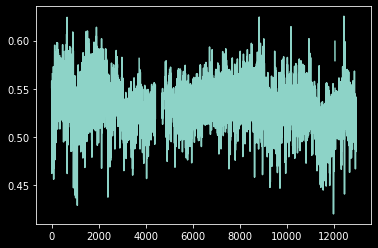

In [16]:
plt.plot(fin["Bitcoin"].values)
plt.show()

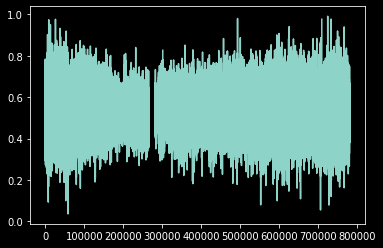

In [19]:
plt.plot(df["Bitcoin"].values)
plt.show()

In [35]:
# from minutes to higher timeframes (days)
df["day"] =  df.datetime.map(lambda x: x[:-8]+"00:00:00")
sentiment = df.groupby(['day']).Bitcoin.apply(np.mean)
open1 = pd.DataFrame(df.groupby(['day']).Open.first())
close = pd.DataFrame(df.groupby(['day']).Close.last())
volume = pd.DataFrame(df.groupby(['day'])['Volume_(Currency)'].sum())
fin = pd.merge(open1,close,on='day')
fin = pd.merge(fin,volume,on='day')
fin = pd.merge(fin,sentiment,on='day')

In [36]:
fin

,Open,Close,Volume_(Currency),Bitcoin
day,,,,
2017-08-01 00:00:00,2855.81,2731.00,3.515865e+07,0.515075
2017-08-02 00:00:00,2732.00,2703.51,2.599996e+07,0.524551
2017-08-03 00:00:00,2703.51,2793.37,2.241777e+07,0.523583
2017-08-04 00:00:00,2793.34,2855.00,2.221897e+07,0.512968
2017-08-05 00:00:00,2851.01,3263.62,5.441609e+07,0.531074
...,...,...,...,...
2019-01-18 00:00:00,3638.01,3609.21,1.923115e+07,0.526857
2019-01-19 00:00:00,3609.29,3681.00,1.630017e+07,0.521660
2019-01-20 00:00:00,3680.00,3536.72,2.107788e+07,0.523376


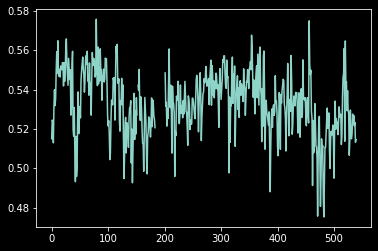

In [37]:
plt.plot(fin["Bitcoin"].values)

plt.show()

In [ ]:
#itterate folder for all raw textual data
txt_folder = Path(TEXTUAL_RAW_DATA_FILEPATH).rglob('*.csv')
paths = [x for x in txt_folder]

i = 1

# final dataframe
df = pd.DataFrame()
weighted = False

start = timer()
for path in paths:

    message = "Iterration " + str(i) + " of " + str(len(paths))
    print(message)
    text_data = preprocess_textual(path)
    
#     old approach
#     timetable = topic_recognition(text_data, flagged_usernames = [], display = message)
#     print(timetable)
    
    #initialize an NLP_preprocess object for the current dataset
    text = NLP_preprocess(text_data)
    
    #print(text.df.shape[0])
    text.flag_users()
    
    
    #basic nlp preprocessing (rm stopwords, rm punctuation etc.)
    text.preprocess_data()
    #perform some spam filtering
    text.spam_filtering()
    
    #print(text.df.shape[0])
    
    #import default tokenizer for the model
    text.import_tokenizer()
    #tokenize and pad text sequences of the dataset
    df_padded = text.tokenize_and_pad(train = False)
        
    #apply the model on the padded sequences to get sentiment
    text.df["sentiment"] = (model.predict(df_padded))
    #print(text.df.index)
    
#     for r in np.random.randint(0,text.df.shape[0],10):
#         print(text.df.iloc[r]['text'], text.df.iloc[r]['sentiment'])


    #try: weight messeges by the average optimism/pessimism of each user
    #this might have an impact because there are about 5.5 messages per user,
    #so there is some history about them
    if weighted:
        text.df['weighted'] = text.df.index.map(lambda x: user_update(text.df.loc[x]['username'],  text.df.loc[x]['sentiment'])) 
    #print(text.df)
    #add an "hour" column that contains the datetime in hourly resolution
    text.df["hour"] =  text.df.date.map(lambda x: x[:-6])
    
    #old
#     timetable = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.mean).values, columns = ["Bitcoin"])
#     timetable2 = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.median).values, columns = ["Bitcoin_median"])
    

    #and then get the mean and median weighted sentiment per hour
    if weighted:
        #we can eliminate the big effect of users that sent multiple messages by first averaging per user per hour
        user_averaged = text.df.groupby(['hour', 'username'], as_index=False).weighted.apply(np.mean)
        timetable = pd.DataFrame(user_averaged.groupby(['hour']).weighted.apply(np.mean).values, columns = ["Bitcoin"])
        timetable2 = pd.DataFrame(user_averaged.groupby(['hour']).weighted.apply(np.median).values, columns = ["Bitcoin_median"])
    else:
        #we can eliminate the big effect of users that sent multiple messages by first averaging per user per hour
        user_averaged = text.df.groupby(['hour', 'username'], as_index=False).sentiment.apply(np.mean)
#         timetable = pd.DataFrame(user_averaged.groupby(['hour']).sentiment.apply(np.mean).values, columns = ["Bitcoin"])
#         timetable2 = pd.DataFrame(user_averaged.groupby(['hour']).sentiment.apply(np.median).values, columns = ["Bitcoin_median"])
        
        timetable = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.mean).values, columns = ["Bitcoin"])
        timetable2 = pd.DataFrame(text.df.groupby(['hour']).sentiment.apply(np.median).values, columns = ["Bitcoin_median"])
    
    #get the mean and median weighted sentiment per hour
#     timetable = pd.DataFrame(text.df.groupby(['hour']).weighted.apply(np.mean).values, columns = ["Bitcoin"])
#     timetable2 = pd.DataFrame(text.df.groupby(['hour']).weighted.apply(np.median).values, columns = ["Bitcoin_median"])
     
    #sync the price and sentiment dataset so that on each row price follows the sentiment
    timetable = timetable[:-1]
    timetable2 = timetable2[:-1]
    btc_connected = connect_datasets(text.df, btc_data)[1:]
    
    i += 1
    #if mismatching sizes disregard current dataset
    if len(timetable.index) != len(btc_connected.index):
        continue
    #otherwise combine them into a single dataset 
    timetable.index = btc_connected.index
    timetable2.index = btc_connected.index
    timetable = pd.concat([timetable['Bitcoin'], timetable2['Bitcoin_median'], btc_connected['open'],btc_connected['close']], axis = 1)
    print(timetable)
    
    df = pd.concat([df, timetable], axis = 0)   
    #print(df)

#save final dataset
df.to_csv(OUTPUT_DATASET_FILEPATH)
print(timer() - start)


### Evaluation and Testing (not important for now)

In [8]:
df2 = pd.read_csv(OUTPUT_DATASET_FILEPATH, index_col = 0)

AttributeError: module 'pandas' has no attribute 'csv_read'

In [ ]:
DATASET_FILEPATH = "./Dataset_sentiment_100K_glove_filtered_2g.csv"
df2 = pd.read_csv(OUTPUT_DATASET_FILEPATH, index_col = 0)
fig = plt.figure(figsize=(18, 10))
plt.plot(range(0,100), -1*df2['Bitcoin'].values[:100])

In [ ]:
fig = plt.figure(figsize=(18, 10))
x = -df2['Bitcoin'][100:200]
x = x/x[0]
y = df2['Open'][100:200]
y = y/y[0]
plt.plot(range(0,100), x)
plt.plot(range(0,100), y)


In [ ]:
fig = plt.figure(figsize=(18, 10))
plt.plot(range(0,100), df.pct_change()['Open'].values[100:200])

In [ ]:
import random
i = random.randint(0,len(text_data.index))
print(text_data.loc[i]['text'])
print(text_data.loc[i]['sentiment'])

In [ ]:
#BTC price data of the next hour standarized
Y = pd.DataFrame(df['Open']).astype(float)
#Y = dataset_standarization(Y)

#Textual data ('Bitcoin' topic popularity) of the last hour standarized
X = pd.DataFrame(df['Bitcoin']).astype(float)
#X = dataset_standarization(X)
Y.index = X.index

X = sm.add_constant(X)

model = sm.OLS(Y, X, missing = 'drop').fit()

In [ ]:
model.summary()

In [64]:
class g(object):
    def __init__(self):
        self.s=None
        self.t=0
    def generator_thr_iter(self,s1):
        if self.t==0 or self.s == None:
            self.s = s1
            self.t = 1
        else:
            self.s += s1
            self.t += 1
        return self.s/self.t

In [65]:
g = g()

In [83]:
print(g.generator_thr_iter(0))

0.5555555555555556


In [88]:
x = [1,2]

In [89]:
x[0] = x[0]+ 1

In [149]:
embedding_dict

{'<user>': array([ 0.63006  ,  0.65177  ,  0.25545  ,  0.018593 ,  0.043094 ,
         0.047194 ,  0.23218  ,  0.11613  ,  0.17371  ,  0.40487  ,
         0.022524 , -0.076731 , -2.2911   ,  0.094127 ,  0.43293  ,
         0.041801 ,  0.063175 , -0.64486  , -0.43657  ,  0.024114 ,
        -0.082989 ,  0.21686  , -0.13462  , -0.22336  ,  0.39436  ,
        -2.1724   , -0.39544  ,  0.16536  ,  0.39438  , -0.35182  ,
        -0.14996  ,  0.10502  , -0.45937  ,  0.27729  ,  0.8924   ,
        -0.042313 , -0.009345 ,  0.55017  ,  0.095521 ,  0.070504 ,
        -1.1781   ,  0.013723 ,  0.17742  ,  0.74142  ,  0.17716  ,
         0.038468 , -0.31684  ,  0.08941  ,  0.20557  , -0.34328  ,
        -0.64303  , -0.878    , -0.16293  , -0.055925 ,  0.33898  ,
         0.60664  , -0.2774   ,  0.33626  ,  0.21603  , -0.11051  ,
         0.0058673, -0.64757  , -0.068222 , -0.77414  ,  0.13911  ,
        -0.15851  , -0.61885  , -0.10192  , -0.47     ,  0.19787  ,
         0.42175  , -0.18458  ,  0.080

In [153]:
# embedding_dict = {}
# EMBEDDINGS_FILEPATH = "../glove.twitter.27B.100d.txt"
# embedding_dict = {}
# with open(EMBEDDINGS_FILEPATH, "r", encoding="utf8") as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vectors = np.asarray(values[1:], "float32")
#         embedding_dict[word] = vectors
# f.close()
word_index = {'<user>':2, 'apple':1}
# + 2 beacause of oov
num_words = len(word_index) + 2
embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

In [156]:
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0